# Multimodal Distribution Analysis according to a categorical variable with Bhattacharyya distance

In [1]:
import pandas as pd

### functions

In [26]:
"""
The function bhatta_dist() calculates the Bhattacharyya distance between two classes on a single feature.
    The distance is positively correlated to the class separation of this feature. Four different methods are
    provided for calculating the Bhattacharyya coefficient.
Created on 4/14/2018
Author: Eric Williamson (ericpaulwill@gmail.com)
"""
import numpy as np
from math import sqrt
from scipy.stats import gaussian_kde
import itertools

def bhatta_dist(X1, X2, method='continuous'):
    #Calculate the Bhattacharyya distance between X1 and X2. X1 and X2 should be 1D numpy arrays representing the same
    # feature in two separate classes. 

    def get_density(x, cov_factor=0.1):
        #Produces a continuous density function for the data in 'x'. Some benefit may be gained from adjusting the cov_factor.
        density = gaussian_kde(x)
        density.covariance_factor = lambda:cov_factor
        density._compute_covariance()
        return density

    #Combine X1 and X2, we'll use it later:
    cX = np.concatenate((X1,X2))

    if method == 'noiseless':
        ###This method works well when the feature is qualitative (rather than quantitative). Each unique value is
        ### treated as an individual bin.
        uX = np.unique(cX)
        A1 = len(X1) * (max(cX)-min(cX)) / len(uX)
        A2 = len(X2) * (max(cX)-min(cX)) / len(uX)
        bht = 0
        for x in uX:
            p1 = (X1==x).sum() / A1
            p2 = (X2==x).sum() / A2
            bht += sqrt(p1*p2) * (max(cX)-min(cX))/len(uX)

    elif method == 'hist':
        ###Bin the values into a hardcoded number of bins (This is sensitive to N_BINS)
        N_BINS = 10
        #Bin the values:
        h1 = np.histogram(X1,bins=N_BINS,range=(min(cX),max(cX)), density=True)[0]
        h2 = np.histogram(X2,bins=N_BINS,range=(min(cX),max(cX)), density=True)[0]
        #Calc coeff from bin densities:
        bht = 0
        for i in range(N_BINS):
            p1 = h1[i]
            p2 = h2[i]
            bht += sqrt(p1*p2) * (max(cX)-min(cX))/N_BINS

    elif method == 'autohist':
        ###Bin the values into bins automatically set by np.histogram:
        #Create bins from the combined sets:
        # bins = np.histogram(cX, bins='fd')[1]
        bins = np.histogram(cX, bins='doane')[1] #Seems to work best
        # bins = np.histogram(cX, bins='auto')[1]

        h1 = np.histogram(X1,bins=bins, density=True)[0]
        h2 = np.histogram(X2,bins=bins, density=True)[0]

        #Calc coeff from bin densities:
        bht = 0
        for i in range(len(h1)):
            p1 = h1[i]
            p2 = h2[i]
            bht += sqrt(p1*p2) * (max(cX)-min(cX))/len(h1)

    elif method == 'continuous':
        ###Use a continuous density function to calculate the coefficient (This is the most consistent, but also slightly slow):
        N_STEPS = 200
        #Get density functions:
        d1 = get_density(X1)
        d2 = get_density(X2)
        #Calc coeff:
        xs = np.linspace(min(cX),max(cX),N_STEPS)
        bht = 0
        for x in xs:
            p1 = d1(x)
            p2 = d2(x)
            bht += sqrt(p1*p2)*(max(cX)-min(cX))/N_STEPS

    else:
        raise ValueError("The value of the 'method' parameter does not match any known method")

    ###Lastly, convert the coefficient into distance:
    if bht==0:
        return float('Inf')
    else:
        return -np.log(bht)


def bhatta_dist2(x, Y, Y_selection=None, method='continuous'):
    #Same as bhatta_dist, but takes different inputs. Takes a feature 'x' and separates it by class ('Y').
    if Y_selection is None:
        Y_selection = list(set(Y))
    #Make sure Y_selection is just 2 classes:
    if len(Y_selection) != 2:
        raise ValueError("Use parameter Y_selection to select just 2 classes.")
    #Separate x into X1 and X2:
    X1 = np.array(x,dtype=np.float64)[Y==Y_selection[0]]
    X2 = np.array(x,dtype=np.float64)[Y==Y_selection[1]]
    #Plug X1 and X2 into bhatta_dist():
    return bhatta_dist(X1, X2, method=method)


def max_bhatta_dist(array_var_num:np.array, array_var_car:np.array, method='continuous'):
    #Same as bhatta_dist, but takes different inputs. Takes a feature 'x' and separates it by class ('Y').
    array_var_car_selection = list(set(array_var_car))
    # labels combinations of categorical variable
    combs = list(itertools.combinations(array_var_car_selection,r=2))
    # initialize
    distances = list()
    # loop of combinations
    for icomb in combs:    
        #Separate x into X1 and X2:
        X1 = np.array(array_var_num, dtype=np.float64)[array_var_car==icomb[0]]
        X2 = np.array(array_var_num, dtype=np.float64)[array_var_car==icomb[1]]
        #Plug X1 and X2 into bhatta_dist():
        d =  bhatta_dist(X1, X2, method=method)
        # append
        distances.append(d)
        # clean
        del d, X1, X2
    # return maximum value of distances
    return np.max(distances)

## TEST functions

In [3]:
def plot_hist(variable):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    dataset[dataset['class'] == Y_SELECTION[0]][variable].plot(kind = "hist", color = 'b', ax = ax, alpha = .5, bins = 20)
    dataset[dataset['class'] == Y_SELECTION[1]][variable].plot(kind = "hist", color = 'g', ax = ax, alpha = .5, bins = 20)
    plt.show()

Bhattacharyya distance of sepal-length: 0.77


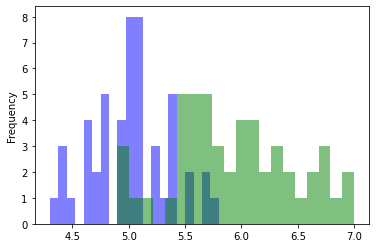

Bhattacharyya distance of sepal-width: 0.70


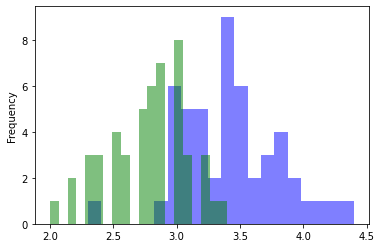

Bhattacharyya distance of petal-length: 124.34


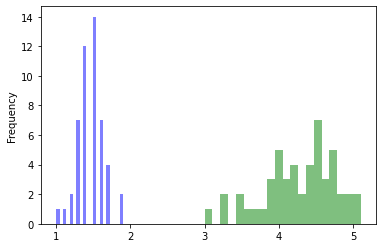

Bhattacharyya distance of petal-width: 82.08


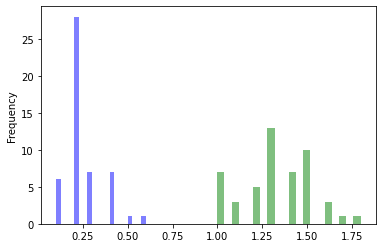

Feature ranking:
['petal-length' 'petal-width' 'sepal-length' 'sepal-width']


In [4]:
import pandas
import numpy as np

###Download the iris data set and separate the feature matrix from the class array.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
dataset = pandas.read_csv(url, names=names+['class'])
array = dataset.values
n_features = array.shape[1]-1
X = array[:,0:-1]
Y = array[:,-1:].reshape(-1)

###For this example we will just look at the Bhattacharyya distance between the 'versicolor' class and the 'setosa' class.
Y_SELECTION = ['Iris-setosa', 'Iris-versicolor']
bh_dists = np.zeros(n_features)
for i,name in enumerate(names):
    #Take the i-th feature and divide it by class:
    X1 = np.array(X[:,i],dtype=np.float64)[Y==Y_SELECTION[0]]
    X2 = np.array(X[:,i],dtype=np.float64)[Y==Y_SELECTION[1]]
    #Call the Bhattacharyya distance function (we'll just use the default method)
    bh_dists[i] = bhatta_dist(X1, X2)

#Print the result for each feature:
for name,d in zip(names,bh_dists):
    print("Bhattacharyya distance of {}: {:.2f}".format(name, d))
    plot_hist(name)
#Use the results to rank features:
print("Feature ranking:")
print(np.array(names)[bh_dists.argsort()[::-1]])

> NOTA: This distance could be used to feature selection.

## REVIEW with synthetic data

In [5]:
np.random.choice(np.ones(1000), size=5, replace=True)

array([1., 1., 1., 1., 1.])

### uniform example

Bhattacharyya distance: 0.03


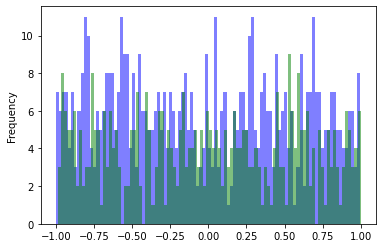

In [6]:
# random data
s = np.random.uniform(-1,1,1000)
c = np.ones(1000)
indices =  np.random.randint(0, high=1000, size=500)
c[indices] = 0
# to df
datarandom = pd.DataFrame({'n0':s, 'c0': c})
# calculate distance
X1 = datarandom[datarandom.c0 == 1].n0.values
X2 = datarandom[datarandom.c0 == 0].n0.values
d = bhatta_dist(X1, X2, method='continuous')
print("Bhattacharyya distance: {:.2f}".format(d))
# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
datarandom[datarandom.c0==1].n0.plot(kind = 'hist', bins = 100, color = 'b', alpha = .5, ax = ax)
datarandom[datarandom.c0==0].n0.plot(kind = 'hist', bins = 100, color = 'g', alpha = .5, ax = ax)
plt.show()

Bhattacharyya distance: 3.12


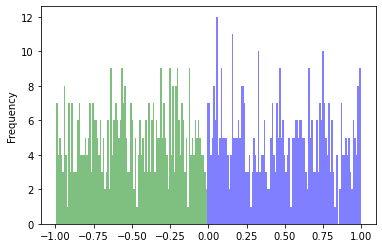

In [7]:
# random data
s = np.sort(np.random.uniform(-1,1,1000))
c = np.ones(1000)
c[0:500] = 0
# to df
datarandom = pd.DataFrame({'n0':s, 'c0': c})
# calculate distance
X1 = datarandom[datarandom.c0 == 1].n0.values
X2 = datarandom[datarandom.c0 == 0].n0.values
d = bhatta_dist(X1, X2, method='continuous')
print("Bhattacharyya distance: {:.2f}".format(d))
# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
datarandom[datarandom.c0==1].n0.plot(kind = 'hist', bins = 100, color = 'b', alpha = .5, ax = ax)
datarandom[datarandom.c0==0].n0.plot(kind = 'hist', bins = 100, color = 'g', alpha = .5, ax = ax)
plt.show()

### gaussian (2 nodes)

Bhattacharyya distance for Gaussians mu1 = 0 / mu2 = 0: 0.12


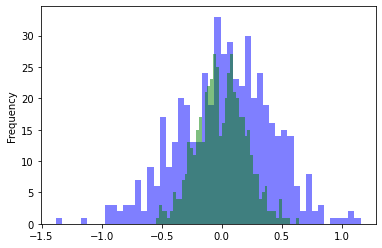

Bhattacharyya distance for Gaussians mu1 = 0 / mu2 = 1: 1.50


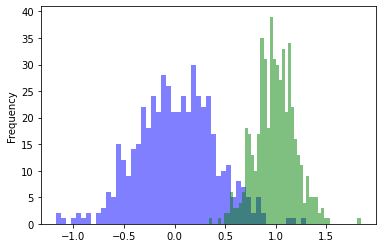

Bhattacharyya distance for Gaussians mu1 = 0 / mu2 = 2: 26.10


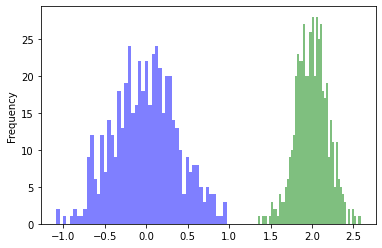

Bhattacharyya distance for Gaussians mu1 = 0 / mu2 = 3: 94.16


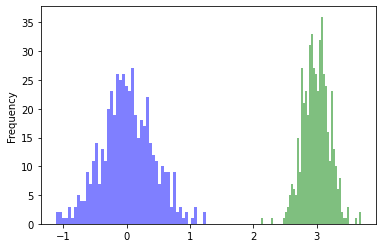

Bhattacharyya distance for Gaussians mu1 = 0 / mu2 = 4: inf


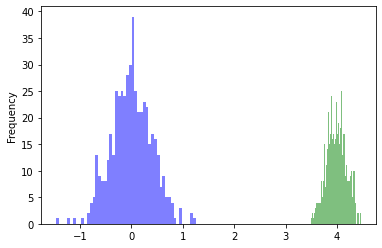

In [8]:
# loop of avg values
for imu in np.arange(0,5,1):
    ## Multimodal
    mu1, sigma1 = 0, 0.4 # mean and standard deviation
    mu2, sigma2 = imu, 0.2 # mean and standard deviation
    s1 = np.random.normal(mu1, sigma1, 500)
    s2 = np.random.normal(mu2, sigma2, 500)
    c1 = np.ones(500, dtype = bool)
    c2 = np.zeros(500, dtype = bool)
    s = np.concatenate((s1, s2))
    c = np.concatenate((c1, c2))
    datagauss = pd.DataFrame({'numerical':s, 'categorical':c})
    # estimate distance
    d = bhatta_dist(s1, s2, method='continuous')
    print("Bhattacharyya distance for Gaussians mu1 = {} / mu2 = {}: {:.2f}".format(mu1, mu2, d))
    ## plot
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    datagauss[datagauss['categorical'] == True]['numerical'].plot(kind = "hist", color = 'b', ax = ax, bins = 50, alpha = .5)
    datagauss[datagauss['categorical'] == False]['numerical'].plot(kind = "hist", color = 'g', ax = ax, bins = 50, alpha = .5)
    plt.show()

## TEST maximum of Bhattacharyya distance for multilabel categorical variable

Bhattacharyya distance for Gaussians mu1 = 1 / mu2 = 1.5 / mu3 = 0: 7.76


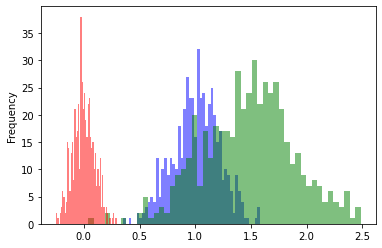

Bhattacharyya distance for Gaussians mu1 = 1 / mu2 = 1.5 / mu3 = 1: 0.78


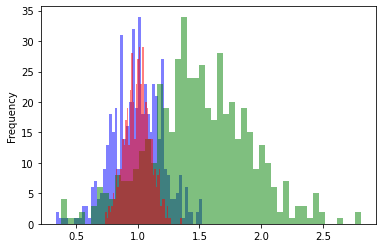

Bhattacharyya distance for Gaussians mu1 = 1 / mu2 = 1.5 / mu3 = 2: 23.84


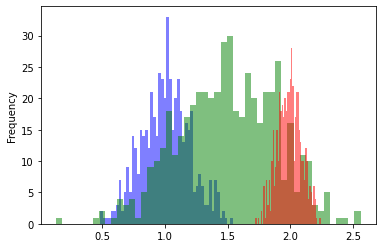

Bhattacharyya distance for Gaussians mu1 = 1 / mu2 = 1.5 / mu3 = 3: inf


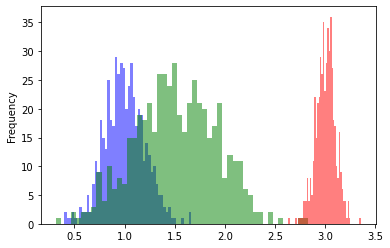

In [30]:
# loop of avg values
for imu in np.arange(0,4,1):
    ## Multimodal
    mu1, sigma1 = 1, 0.2 # mean and standard deviation
    mu2, sigma2 = 1.5, 0.4 # mean and standard deviation
    mu3, sigma3 = imu, 0.1 # mean and standard deviation
    s1 = np.random.normal(mu1, sigma1, 500)
    s2 = np.random.normal(mu2, sigma2, 500)
    s3 = np.random.normal(mu3, sigma3, 500)
    c1 = np.ones(500, dtype = bool)
    c2 = np.ones(500, dtype = bool) * 2
    c3 = np.ones(500, dtype = bool) * 3
    s = np.concatenate((s1, s2, s3))
    c = np.concatenate((c1, c2, c3))
    datagauss = pd.DataFrame({'numerical':s, 'categorical':c})
    # estimate distances
    array_var_num = datagauss['numerical'].values
    array_var_car = datagauss['categorical'].values
    max_d = max_bhatta_dist(array_var_num, array_var_car, method='continuous')
    print("Bhattacharyya distance for Gaussians mu1 = {} / mu2 = {} / mu3 = {}: {:.2f}".format(mu1, mu2, mu3, max_d))
    ## plot
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    datagauss[datagauss['categorical'] == 1]['numerical'].plot(kind = "hist", color = 'b', ax = ax, bins = 50, alpha = .5)
    datagauss[datagauss['categorical'] == 2]['numerical'].plot(kind = "hist", color = 'g', ax = ax, bins = 50, alpha = .5)
    datagauss[datagauss['categorical'] == 3]['numerical'].plot(kind = "hist", color = 'r', ax = ax, bins = 50, alpha = .5)
    plt.show()

inf